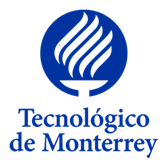

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 3

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v2.00.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3


In [2]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
# logging.basicConfig(
#    filename='../logs/Avance3_Equipo37_Bedrock_Baseline.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [3]:
# Configurando constantes para la ejecución. AWS_KBID contiene el identificador de la base de conocimientos de AWS Bedrock
LOCAL_SET = '../local-responses'
AWS_KBID = 'DT9APRDIVV'


### **Evaluando la Base de Conocimiento y el Modelo Fundacional**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Durante estas pruebas se hará una evaluación cualitativa de las repuestas. Para este efecto cada participante del equipo proveerá una calificación de la respuesta indicando si la respuesta es o no correcta, si es precisa o imprecisa y si está o no basada en los hechos de referencia. La calificación se evalúa en una escala del 1 al 5 como sigue (Grech, 2024):

1. La respuesta es completamente incorrecta, imprecisa y/o no basada en los hechos
2. La respuesta es en su mayoría incorrecta, imprecisa y/o no basada en los hechos
3. La respuesta es de alguna manera correcta, precisa y/o basada en los hechos
4. La respuesta es en su mayoría correcta, precisa y/o basada en los hechos
5. La respuesta es completamente correcta, precisa y/o basada en los hechos


### **Creando Sesión de AWS Bedrock**

In [4]:
# Creando sesion para AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
bedrock_agent_runtime = boto3.client(
    "bedrock-agent-runtime"
)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [5]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(input, kbid, runtime):
    start_time = time.time()
    response = runtime.retrieve_and_generate(
        input = {
          'text': input  
        },
        retrieveAndGenerateConfiguration = {
            'type': 'KNOWLEDGE_BASE',
            'knowledgeBaseConfiguration': {
                'knowledgeBaseId': kbid,
                'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-premier-v1:0'
                }
        }
    )
    elapsed_time = time.time() - start_time
    return elapsed_time, response
    

In [6]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['output']['text']}")
    for citation in response['citations']:
        print(f"\nCita:\n{citation['generatedResponsePart']['textResponsePart']['text']}")
        print('Referencias:')
        for reference in citation['retrievedReferences']:
            print(f"\nNombre del hotel: {reference['metadata']['Name']}, Ciudad: {reference['metadata']['City']}, Direccion: {reference['metadata']['Address']}")
            print(f"\nPais: {reference['metadata']['Country']}, Continente:{reference['metadata']['Continent']}, URI:{reference['metadata']['x-amz-bedrock-kb-source-uri']}")
            print(f"<< {reference['content']['text']} >>")


### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [7]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 5.2205 segundos:
I could not find an exact answer to the question, but I did find some information that may be relevant.

The Pilanesberg National Park is about 70 km away from the property. The hotel is situated at the heart of the Waterberg in a wildlife reserve in the Limpopo province. The hotel is located 130 km from Nylstroom and around 150 km from Mabula Lodge and Kwafubesi Toll Plaza. Sandton and Johannesburg International Airport lie 260 km/ a 3-hour drive away. Pretoria lies approximately 210 km from the hotel, whilst Sun City is 330 km away. 

I hope this information helps.

Cita:
I could not find an exact answer to the question, but I did find some information that may be relevant.

The Pilanesberg National Park is about 70 km away from the property
Referencias:

Nombre del hotel: woodridge palms boutique hotel, Ciudad: Millvale, Direccion: woodstock steenbokfontein, 1245 millvale, millvale, 1245, south africa

Pais: South Africa, Continente:Africa, URI:

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 1 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [8]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.0540 segundos:
I could not find an exact answer to the question, but I found that there is a hotel in Limpopo province, which is near the North West Province.

Cita:
I could not find an exact answer to the question, but I found that there is a hotel in Limpopo province, which is near the North West Province
Referencias:

Nombre del hotel: shidzidzi and nungubane private game lodge, Ciudad: Vaalwater, Direccion: waterberg nature conservancy, waterbergvaalwater 0530, vaalwater, 530, south africa

Pais: South Africa, Continente:Africa, URI:s3://chunked-hotel-data/1129025-d410acd6188911ef9eac16ffcf11486b.txt
<< HotelDescription#The hotel is situated at the heart of the Waterberg in a wildlife reserve in the Limpopo province. Shidzidzi and Nungubane are only 3 km from the hotel. The hotel is located 130 km from Nylstroom and around 150 km from Mabula Lodge and Kwafubesi Toll Plaza. Sandton and Johannesburg International Airport lie 260 km/ a 3-hour drive away. Pretori

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 1 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [9]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 3.1411 segundos:
When you stay at Black Rhino Game Lodge in Pilanesberg National Park, you'll be in a national park and 13 minutes by foot from Pilanesberg National Park. This 4-star lodge is 22.1 mi (35.6 km) from Sun City Casino and 22.5 mi (36.1 km) from The Valley of Waves.

Cita:
When you stay at Black Rhino Game Lodge in Pilanesberg National Park, you'll be in a national park and 13 minutes by foot from Pilanesberg National Park. This 4-star lodge is 22.1 mi (35.6 km) from Sun City Casino and 22.5 mi (36.1 km) from The Valley of Waves.
Referencias:

Nombre del hotel: black rhino game lodge, Ciudad: Pilanesberg National Park, Direccion: r565 black rhino game reserve, black rhino game reservepilanesberg 7130pilanesberg national park, pilanesberg national park, 2128, south africa

Pais: South Africa, Continente:Africa, URI:s3://chunked-hotel-data/1167213-3bacf31e188911ef9eac16ffcf11486b.txt
<< HeadLine : In a national parkLocation : When you stay at Black Rhino 

**Respuesta de Copilot Edge**

The Black Rhino Game Lodge is nestled in the west side of the malaria-free Pilanesberg National Park in the North West Province of South Africa. Here are some attractions near the lodge:

Pilanesberg National Park: The park itself is a must-visit, covering an area of 55,000 hectares. It’s home to the Big Five (elephant, buffalo, leopard, lion, and rhinoceros), as well as other wildlife like wild dogs, hippos, and various bird species12.
Sun City: Only 33 km away from the lodge, Sun City is a popular entertainment hotspot. You can explore its casinos, golf courses, water parks, and cultural attractions1.
Tambuti Lodge: Located in the northwestern side of Pilanesberg National Park, Tambuti Lodge offers spacious and luxurious accommodation surrounded by the trees of the old Tamboti forest. It’s an excellent option for visitors seeking a unique safari experience3.
Kgorogoro Lodge (Morokolo Safari Lodge): Situated on the northern slopes of the Pilanesberg mountains, Kgorogoro Lodge boasts rich varieties of African wildlife, fauna, and flora. You can book either the 4 Suite Lodge or the Executive Suite for a memorable stay4.
Remember that the Black Rhino Game Reserve and the greater Pilanesberg National Park are only about 2.5 hours’ drive from Johannesburg, Pretoria, and the OR Tambo International Airport, making it easily accessible for travelers1. Enjoy your bushveld adventure! raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [10]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 1.5594 segundos:
You can try Cape Village Lodge in Cape Town, Western Cape Province in South Africa.

Cita:
You can try Cape Village Lodge in Cape Town, Western Cape Province in South Africa
Referencias:

Nombre del hotel: cape village lodge, Ciudad: Durbanville, Direccion: 19 mills street, valmary park, valmary parkdurbanville 7550western cape, durbanville, 7550, south africa

Pais: South Africa, Continente:Africa, URI:s3://chunked-hotel-data/1775684-1ae4cc2a188811ef9eac16ffcf11486b.txt
<< HeadLine : In Cape Town (Welgemoed)Location : With a stay at Cape Village Lodge in Cape Town (Welgemoed), you ll be within a 5-minute drive of Durbanville Golf Club and Nitida Cellars.  This 4-star guesthouse is 2.8 mi (4.5 km) from Tyger Valley Shopping Centre and 3 mi (4.8 km) from Willowbridge Shopping Centre.Rooms : Make yourself at home in one of the 4 guestrooms featuring minibars and Smart televisions. Rooms have private patios. Complimentary wireless Internet access keep

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of accommodation options. Here are a few recommendations:

The Glen Boutique Hotel & Spa: A 5-star stay in Sea Point, Cape Town. Enjoy luxurious rooms with modern furniture, private bathrooms, and stunning views of the mountains or the Atlantic Ocean. The hotel features a spa, pool, and complimentary breakfast buffet1.
Radisson Blu Hotel Waterfront: Another 5-star option with breathtaking views of Table Mountain or the ocean. The hotel offers free Wi-Fi, a private marina, and water sports activities. It’s close to the V&A Waterfront and the CBD2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, apartments, and townhouses in Cape Town. You can find places with ocean views, private pools, and stylish interiors34.
Remember to explore the Sea Point promenade, nearby beaches, and iconic attractions during your stay. Enjoy your trip!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 3 |
| JC Alvarado | 3 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [7]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 3.1523 segundos:
Here are some accommodations in Cape Town, Western Cape Province, South Africa, with a minimum rating of 4:
- Cape Village Lodge - This apartment - This vacation home

Cita:
Here are some accommodations in Cape Town, Western Cape Province, South Africa, with a minimum rating of 4:
- Cape Village Lodge
Referencias:

Nombre del hotel: cape village lodge, Ciudad: Durbanville, Direccion: 19 mills street, valmary park, valmary parkdurbanville 7550western cape, durbanville, 7550, south africa

Pais: South Africa, Continente:Africa, URI:s3://chunked-hotel-data/1775684-1ae4cc2a188811ef9eac16ffcf11486b.txt
<< HeadLine : In Cape Town (Welgemoed)Location : With a stay at Cape Village Lodge in Cape Town (Welgemoed), you ll be within a 5-minute drive of Durbanville Golf Club and Nitida Cellars.  This 4-star guesthouse is 2.8 mi (4.5 km) from Tyger Valley Shopping Centre and 3 mi (4.8 km) from Willowbridge Shopping Centre.Rooms : Make yourself at home in one of 

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of 4-star accommodation options. Here are some recommendations:

Home Suite Hotels Station House: Located in Sea Point, this hotel provides an outdoor swimming pool, free private parking, a fitness center, and a terrace. Guests can also enjoy a bar12.
Home Suite Hotels Sea Point: Set in Cape Town, near Three Anchor Bay Beach, this hotel features an outdoor swimming pool, shared lounge, and terrace. Some units even have a balcony with city views12.
O’ Two Hotel: Situated in Mouille Point, this hotel offers free bikes, an outdoor swimming pool, fitness center, and a terrace. It’s close to Mouille Point Beach and Three Anchor Bay Beach12.
Romney Park Luxury Apartments: Located in Green Point, this 5-star aparthotel offers spacious apartments with kitchen facilities, en-suite bathrooms, and outdoor balconies with panoramic views12.
Remember to explore the nearby attractions and enjoy your stay in beautiful Cape Town!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 3 |
| JC Alvarado | 3 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [12]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.1519 segundos:
I could not find an exact answer to the question, but I did find a 4-star lodge in Hoedspruit.

Cita:
I could not find an exact answer to the question, but I did find a 4-star lodge in Hoedspruit
Referencias:

Nombre del hotel: twiga travel, Ciudad: Hoedspruit, Direccion: 542 ghwarrie road hoedspruit wildlife estate, hoedspruit wildlife estatehoedspruit 1380, hoedspruit, 1380, south africa

Pais: South Africa, Continente:Africa, URI:s3://chunked-hotel-data/1822395-01beff68188d11ef9eac16ffcf11486b.txt
<< HeadLine : In HoedspruitLocation : With a stay at Twiga Travel in Hoedspruit, you ll be 13.2 mi (21.2 km) from Jessica the Hippo and 15.1 mi (24.2 km) from Hoedspruit Endangered Species Centre.  This 4-star lodge is 22.1 mi (35.6 km) from Moholoholo Wildlife Rehabilitation Centre.Rooms : Make yourself at home in one of the 5 individually decorated guestrooms, featuring refrigerators and microwaves. Your memory foam bed comes with premium bedding. Co

**Respuesta de Copilot Edge**

Certainly! Hoedspruit, located in the Limpopo Province of South Africa, offers a variety of accommodation options. Here are some recommendations:

The Hoedspruit Hotel: This cozy hotel brings the best of Hoedspruit to your doorstep. Enjoy comfortable rooms with flat-screen TVs, air conditioning, and refrigerators. Free parking is available, and it’s conveniently located near popular art galleries and restaurants1.
Sunbirds Oasis Lodge: A tranquil stay in Hoedspruit. Explore the surrounding wildlife and enjoy the peaceful atmosphere2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, self-catering houses, and lodges in Hoedspruit. You can find options with stunning views, private pools, and close proximity to nature reserves3.
Remember to explore the nearby Blyde River Canyon, Kruger National Park, and other natural wonders during your stay.raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 1 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [13]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 3.5354 segundos:
Here are 5 places to stay in Monterrey, Nuevo Leon in Mexico:
1. Auténtico Monterrey 2. Hotel 5 Inn 3. Mex Suites Casa Azúl B&B 4. Hotel Real Inn Nuevo Morelos 5. City Express Monterrey Aeropuerto

Cita:
Here are 5 places to stay in Monterrey, Nuevo Leon in Mexico:
1. Auténtico Monterrey
Referencias:

Nombre del hotel: auténtico monterrey, Ciudad: San Pedro Garza Garcia, Direccion: avenida manuel gómez morín 285 col valle del campestre, , san pedro garza garcia, 66265, mexico

Pais: Mexico, Continente:Americas, URI:s3://chunked-hotel-data/5380060-a1d99eb4188c11ef9eac16ffcf11486b.txt
<< HeadLine : Near Paseo San PedroLocation : With a stay at Auténtico Monterrey in San Pedro Garza García, you ll be connected to a shopping center, within a 10-minute drive of Fundidora Park and Paseo San Pedro.  This 4-star hotel is 4.2 mi (6.8 km) from Macroplaza and 8.7 mi (14 km) from Estadio BBVA Bancomer.Rooms : Stay in one of 33 guestrooms featuring plasma telev

**Respuesta de Copilot Edge**

Certainly! If you’re planning a trip to Monterrey, Nuevo León, here are five great places to stay:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor pool, free parking, and a fitness center. Enjoy panoramic views and excellent service12.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi13.
Galeria Plaza Monterrey: Conveniently situated in the center of Monterrey, this 5-star hotel offers city views, an outdoor pool, and free WiFi. Don’t miss the restaurant and bar13.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Located in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport13.
Fiesta Americana Monterrey Pabellón M.: Situated in Monterrey Centro, this hotel offers an outdoor pool and stunning city views. The on-site restaurant and bar on the 16th floor provide a memorable experience12.
Enjoy your stay in vibrant Monterrey!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 2 |
| JC Alvarado | 2 |
| JC Romo | 2 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [14]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, close to Tec de Monterrey?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 3.2673 segundos:
Here are 5 places to stay in Monterrey, Nuevo Leon in Mexico, close to Tec de Monterrey:
1. Auténtico Monterrey 2. Hyatt Place Monterrey Valle 3. NH Monterrey La Fe 4. Mex Hoteles 5. Hotel Fundador

Cita:
Here are 5 places to stay in Monterrey, Nuevo Leon in Mexico, close to Tec de Monterrey:
1. Auténtico Monterrey
Referencias:

Nombre del hotel: auténtico monterrey, Ciudad: San Pedro Garza Garcia, Direccion: avenida manuel gómez morín 285 col valle del campestre, , san pedro garza garcia, 66265, mexico

Pais: Mexico, Continente:Americas, URI:s3://chunked-hotel-data/5380060-a1d99eb4188c11ef9eac16ffcf11486b.txt
<< HeadLine : Near Paseo San PedroLocation : With a stay at Auténtico Monterrey in San Pedro Garza García, you ll be connected to a shopping center, within a 10-minute drive of Fundidora Park and Paseo San Pedro.  This 4-star hotel is 4.2 mi (6.8 km) from Macroplaza and 8.7 mi (14 km) from Estadio BBVA Bancomer.Rooms : Stay in one of 33 guest

**Respuesta de Copilot Edge**

Certainly! If you’re looking for accommodations near Tec de Monterrey, here are five options to consider:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor swimming pool, free private parking, a fitness center, and a restaurant. Enjoy a comfortable stay with excellent amenities1.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi1.
Galeria Plaza Monterrey: Attractively set in the center of Monterrey, this 5-star hotel offers air-conditioned rooms, an outdoor swimming pool, free Wi-Fi, and a fitness center. Enjoy city views and convenient amenities1.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Situated in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport1.
Fiesta Americana Monterrey Pabellón M.: Offering an outdoor pool and city views, this hotel is located in Monterrey Centro. Enjoy panoramic vistas from the on-site restaurant and bar on the 16th floor1.
These options provide a range of amenities and convenient locations for your stay in vibrant Monterrey!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 3 |
| JC Alvarado | 3 |
| JC Romo | 3 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [15]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.4311 segundos:
I could not find an exact answer to the question, but I found some hotels in Mexico City that have spas:
- Hotel Carrizal Spa - Hotel Rancho Gran Relax - Spa Holistico Real Hotel

Cita:
I could not find an exact answer to the question, but I found some hotels in Mexico City that have spas:
- Hotel Carrizal Spa
Referencias:

Nombre del hotel: hotel carrizal spa, Ciudad: Jalcomulco, Direccion: domicilio conocido congregación agua caliente., congregacion agua caliente91647 apazapan, jalcomulco, 91647, mexico

Pais: Mexico, Continente:Americas, URI:s3://chunked-hotel-data/1132076-8131a88c189611ef9eac16ffcf11486b.txt
<< The hotel is a 45-minute drive from the beautiful town of Coatepec. You can drive to Veracruz in around an hour. Please inform Hotel Carrizal Spa in advance of your expected arrival time. You can use the Special Requests box when booking, or contact the property directly with the contact details provided in your confirmation.
Payment bef

**Respuesta de ChatGpt**

Mexico City offers many luxurious hotels perfect for a romantic weekend. Here are a few options that include massage services within the hotel:

1. Las Alcobas, a Luxury Collection Hotel
Located in the upscale Polanco district, Las Alcobas offers elegant rooms and a serene spa. The hotel features a full-service spa with a variety of massage treatments, ensuring a relaxing experience for you and your wife.

2. The St. Regis Mexico City
This hotel is known for its luxurious amenities and exceptional service. The Remède Spa offers a range of treatments, including massages, facials, and body treatments. The hotel’s central location also provides easy access to many of the city’s attractions.

3. Four Seasons Hotel Mexico City
Situated on the Paseo de la Reforma, this hotel combines luxury with comfort. The spa offers a variety of massage treatments, and you can also enjoy the beautiful garden courtyard and the rooftop pool.

4. Hotel Marquis Reforma
This elegant hotel on Paseo de la Reforma features the Spa Marquis, offering an extensive menu of massages and wellness treatments. It’s a perfect place to unwind and enjoy a romantic weekend.

5. JW Marriott Hotel Mexico City
Located in the Polanco district, this hotel offers a luxurious stay with an on-site spa that provides various massage treatments. The hotel’s prime location also means you’re close to excellent dining and shopping options.

These hotels will provide a romantic and relaxing environment for your weekend getaway.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 2 |
| JC Alvarado | 2 |
| JC Romo | 3 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [16]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.4293 segundos:
I found 3 hotels in Cancun that have their own golf course:
- Villa du Golf à Cancun - Pok-ta-Pok Cancun's hotel - Caracol Vacation Club

Cita:
I found 3 hotels in Cancun that have their own golf course:
- Villa du Golf à Cancun
Referencias:

Nombre del hotel: la villa du golf à cancun, Ciudad: Cancun, Direccion: km 7.5 zona hotelera calle quetzal 32 1, km 7.5boulevard kukulkanzona hotelera, cancun, 77500, mexico

Pais: Mexico, Continente:Americas, URI:s3://chunked-hotel-data/1464982-872f16ac188c11ef9eac16ffcf11486b.txt
<< The Villa du Golf à Cancun is a boutique hotel that offers to stay at home.

With outdoor pool and free parking. All rooms have different styles, free wifi service, air conditioning, private bathroom.

The Villa du Golf à Cancun is located in the hotel zone near the Chedraui Selecto supermarket, the entrance to the public beach Caracol, the nightclub area (Coco Bongo, Mandala), the international convention center (Cancun ICC), as

**Respuesta de ChatGpt**

Cancun offers several excellent hotels with their own golf courses, perfect for a golf weekend. Here are some top recommendations:

1. Moon Palace Cancun
Description: Moon Palace Cancun features a 27-hole Jack Nicklaus Signature golf course. The resort offers luxurious accommodations, multiple dining options, and a range of activities.
Facilities: Golf academy, pro shop, golf packages, spa, and fine dining.
2. Iberostar Cancun
Description: Iberostar Cancun boasts an 18-hole championship golf course designed by Isao Aoki. The resort offers beautiful beachfront views, a variety of restaurants, and numerous amenities.
Facilities: Clubhouse, golf shop, spa, multiple swimming pools, and entertainment options.
3. The Ritz-Carlton, Cancun
Description: The Ritz-Carlton, Cancun, while not having its own golf course, offers access to several nearby courses, including the Iberostar Cancun Golf Club and El Camaleon Mayakoba Golf Club.
Facilities: Luxurious accommodations, fine dining, spa services, and concierge service to arrange golfing activities.
4. Dreams Vista Cancun Golf & Spa Resort
Description: This resort features a Greg Norman-designed golf course at Playa Mujeres Golf Club. The all-inclusive resort provides a range of activities and luxurious accommodations.
Facilities: Golf packages, pro shop, spa, multiple dining options, and rooftop pool.
5. Secrets Playa Mujeres Golf & Spa Resort
Description: An adults-only resort with access to the 18-hole Playa Mujeres Golf Club, designed by Greg Norman. The resort offers all-inclusive luxury, perfect for a golf weekend.
Facilities: Golf packages, pro shop, multiple restaurants, bars, spa, and beachfront access.
Tips for Booking
Early Reservations: Golf courses can get booked up quickly, so make sure to reserve tee times in advance.
Packages: Look for golf packages that include accommodations, meals, and golf rounds to get the best value.
Group Discounts: If you are traveling with a group, inquire about group rates or special deals.
Would you like more information on any of these hotels or assistance with booking?

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 3 |
| JC Alvarado | 3 |
| JC Romo | 2 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [17]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.4317 segundos:
Here are some hotels near Ueno Park in Tokyo:
- Mitsui Garden Hotel Ueno Tokyo - Park Hotel Tokyo - Candeo Hotels Uenokoen

Cita:
Here are some hotels near Ueno Park in Tokyo:
- Mitsui Garden Hotel Ueno Tokyo
Referencias:

Nombre del hotel: mitsui garden hotel ueno, Ciudad: Tokyo, Direccion: 3 19 7 higashi ueno taito ku, taito-kutokyo 110-0015, tokyo, 110-0015, japan

Pais: Japan, Continente:Asia, URI:s3://chunked-hotel-data/1031102-4f6eb656189f11ef9eac16ffcf11486b.txt
<< HeadLine : Near Ueno ParkLocation : With a stay at Mitsui Garden Hotel Ueno Tokyo, you ll be centrally located in Tokyo, within a 5-minute drive of Tokyo Dome and Tokyo Skytree.  This 4-star hotel is 0.3 mi (0.5 km) from Ueno Park and 5.2 mi (8.4 km) from Tokyo Tower.Rooms : Make yourself at home in one of the 242 guestrooms featuring refrigerators and flat-screen televisions. Your bed comes with down comforters and premium bedding. Complimentary wired and wireless Internet access

**Respuesta de ChatGpt**

Here are some recommended hotels near Ueno Park in Tokyo:

1. Hotel Graphy Nezu: This hotel is located about a 15-minute walk from Ueno Park and offers residential-style accommodations with a fully-equipped, shared kitchen. It is well-rated for its good facilities and friendly staff.

2. APA Hotel Ueno Ekimae: Situated in the heart of Tokyo, this hotel provides convenient access to local markets and restaurants. It's known for its good value and includes free WiFi throughout the property.

3. Tosei Hotel Cocone Ueno Okachimachi: This hotel scores highly for cleanliness and value for money. It is located very close to Ueno Park and offers 3-star accommodations.

4. Hop Inn Tokyo Ueno: Located a short walk from Ueno Station, this hotel is noted for its cleanliness and new hotel vibes. It offers air-conditioned rooms and free WiFi, making it a comfortable choice for visitors.

All of these options offer good accessibility to Ueno Park and its surrounding attractions, providing a range of amenities to suit various preferences and budgets.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 3 |
| JC Alvarado | 3 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [18]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 3.1248 segundos:
Here are some hotels in Hakone Japan that offer traditional Japanese Ryokans:
- Hakone Tokinoshizuku - Gyokutei Ryokan - Hakone Yuyado Zen - Shiunso Ryokan - GORA HANAOUGI-SOUNKAKU

Cita:
Here are some hotels in Hakone Japan that offer traditional Japanese Ryokans:
- Hakone Tokinoshizuku
Referencias:

Nombre del hotel: hakone tokinoshizuku, Ciudad: Hakone, Direccion: 416 miyanoshita, ashigarashimo-gunhakone 250-0404kanagawa prefecture, hakone, 250-0404, japan

Pais: Japan, Continente:Asia, URI:s3://chunked-hotel-data/1796379-9d12dd62188e11ef9eac16ffcf11486b.txt
<< Situated in Hakone, Hakone Tokinoshizuku provides 5-star accommodation with private balconies. Among the facilities of this property are a restaurant, a 24-hour front desk and a lift, along with free WiFi. Free private parking is available and the ryokan also features a shuttle service for guests who want to explore the surrounding area.

The ryokan will provide guests with air-conditione

**Respuesta de ChatGpt**

For traditional Japanese ryokans in Hakone, Japan, you might consider the following options:

1. Gora Kadan: This luxurious ryokan offers traditional Japanese accommodations with modern amenities, including hot spring baths and gourmet kaiseki meals.

2. Hakone Ginyu: Situated in the scenic Hakone area, Hakone Ginyu provides elegant ryokan-style rooms with private outdoor hot spring baths and panoramic views of the surrounding mountains.

3. Yamano Hotel: Yamano Hotel offers authentic Japanese hospitality in a tranquil setting. Guests can enjoy traditional tatami mat rooms, communal hot spring baths, and delicious multi-course meals.

4. Gora Hanaougi: Nestled in the heart of Hakone, Gora Hanaougi features spacious ryokan accommodations, soothing hot spring baths, and impeccable service.

5. Hakone Yutowa: This ryokan combines traditional Japanese design with modern comforts, offering guests a relaxing retreat with hot spring baths, gourmet dining, and serene natural surroundings.

These are just a few options to consider for experiencing traditional Japanese hospitality in Hakone. Be sure to check availability and make reservations in advance, especially during peak travel seasons.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 4 |
| JC Alvarado | 4 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [19]:
input = '''Can you recommend hotels in Chihuauha City that are located near Periferico de la Juventud?'''

elapsed_time, response = retrieve_and_generate(input, AWS_KBID, bedrock_agent_runtime)
display_response(response, elapsed_time)

Respuesta despues de 2.0201 segundos:
I could not find an exact answer to the question, but I found that Quinta La Huerta is a hotel in Tlalpujahua de Rayón.

Cita:
I could not find an exact answer to the question, but I found that Quinta La Huerta is a hotel in Tlalpujahua de Rayón
Referencias:

Nombre del hotel: quinta la huerta, Ciudad: Tlalpujahua De Rayon, Direccion: dolores # 19 col. centro, colonia centrotlalpujahua, tlalpujahua de rayon, 61060, mexico

Pais: Mexico, Continente:Americas, URI:s3://chunked-hotel-data/1634216-dd42a3ee188f11ef9eac16ffcf11486b.txt
<< Located in Tlalpujahua de Rayón, 18 km from Tepetongo Water Park, Quinta La Huerta provides accommodation with a fitness centre, free private parking, a garden and a shared lounge. This 4-star hotel offers a restaurant. The hotel features an indoor pool, a 24-hour front desk and free WiFi.

At the hotel, every room is equipped with a wardrobe, a flat-screen TV, a private bathroom, bed linen and towels.

The nearest airpo

**Respuesta de ChatGpt**

I don't have direct access to real-time data or external sources like hotel databases. However, I can suggest a general approach to finding hotels near Periférico de la Juventud in Chihuahua City:

Online Hotel Booking Platforms: Websites like Booking.com, Expedia, or TripAdvisor allow you to search for hotels based on specific locations. You can enter "Periférico de la Juventud" as the location and see the hotels available nearby.

Google Maps: You can use Google Maps to search for hotels near Periférico de la Juventud. Simply type "hotels near Periférico de la Juventud, Chihuahua City" into the search bar, and Google Maps will display a list of hotels in that area along with their ratings and reviews.

Local Directories: Check local business directories or tourism websites for information on hotels near Periférico de la Juventud. They may have listings and contact details for hotels in the area.

Contact Hotels Directly: Once you have a list of potential hotels, you can contact them directly to inquire about their location relative to Periférico de la Juventud and any other details you need to know.

By using these methods, you should be able to find hotels in Chihuahua City that are located near Periférico de la Juventud.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 1 |

## **Conclusiones**


El análisis de la evaluación se encuentra en el archivo ***Proyecto-Integrador-Evaluacion-Avance4.xlsx*** en el mismo repositorio de esta libreta.

La presentación de los nuevos modelos y la selección del mejor modelo se encuentran en el archivo ***Avance4 Smart Travel Assistant-Reporte de Progreso-02.pptx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad
